#Imports

In [ ]:
!pip install svgling

In [ ]:
!pip install ta

In [ ]:
import os
import sys
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
from datetime import datetime
from sklearn.metrics import mean_squared_error

In [ ]:
import yfinance as yf
from urllib.request import Request, urlopen
from svgling import draw_tree
import nltk
from IPython.display import display
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from datetime import datetime

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import ta

#Create DF Function

In [ ]:
def create_df(stock):
    ticker = yf.Ticker(stock)
    df = ticker.history(period="5y")
    del df["Dividends"]
    del df["Stock Splits"]
    df["tomorrow"] = df["Close"].shift(-1)
    df["yesterday"] = df["Close"].shift(1)
    df.dropna(inplace=True)
    df = df.reset_index()
    df['Date'] = df['Date'].astype(str)
    df['Date'] = df['Date'].apply(lambda x: x.split(" ")[0])
    return df

#Web Scrapping

In [ ]:
def convert_date(date_str):
    dt = datetime.strptime(date_str, '%b-%d-%y')
    return dt.strftime('%Y-%m-%d')

In [ ]:
def scrap_data(ticker):
    """Scrape news data from FinViz for a given ticker using only requests + BeautifulSoup"""
    finviz_url = "https://finviz.com/quote.ashx?t="
    url = finviz_url + ticker

    max_retries = 3
    retry_count = 0

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)\
         Chrome/90.0.4430.93 Safari/537.36'
    }

    while retry_count < max_retries:
        try:
            print(f"Attempt {retry_count + 1}: Fetching data for {ticker}...")

            response = requests.get(url, headers=headers, timeout=20)
            response.raise_for_status()

            soup = BeautifulSoup(response.text, "html.parser")

            news_table = soup.find(id="news-table")
            if not news_table:
                raise ValueError(f"Could not find news table for ticker {ticker}")

            news_rows = news_table.find_all("tr")

            parsed_data = []
            current_date = None

            for row in news_rows:
                title_element = row.find('a', class_='tab-link-news')
                if not title_element:
                    continue

                title = title_element.text.strip()

                time_cell = row.td
                if not time_cell:
                    continue

                time_text = time_cell.text.strip()

                if len(time_text.split()) > 1:
                    current_date = time_text.split()[0]

                if current_date:
                    parsed_data.append([current_date, title])

            df = pd.DataFrame(parsed_data, columns=["date", "title"])
            df = df.dropna().reset_index(drop=True)

            df['date'] = df['date'].apply(convert_date)
            df['ticker'] = ticker

            print(f"Successfully scraped {len(df)} news items for {ticker}")
            return df

        except Exception as e:
            retry_count += 1
            print(f"Attempt {retry_count} failed: {str(e)}")
            if retry_count < max_retries:
                print("Retrying...")
                time.sleep(2)
            else:
                print("Max retries reached. Failed to scrape data.")
                return pd.DataFrame(columns=["date", "title", "ticker"])

#Sentiment Analysis

In [ ]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Pa

True

In [ ]:
def compound_scores(df):
  analyzer = SentimentIntensityAnalyzer()
  result = []

  for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['title']
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    chunks = nltk.chunk.ne_chunk(tags)
    sentiment = analyzer.polarity_scores(text)
    compound = sentiment['compound']
    result.append(compound)

  df['compound'] = result
  del df["title"]

  df = df.groupby('date', as_index=False)['compound'].mean()

  return df

#Train Model Function

In [ ]:
def predict_stock_price_lstm(stock_symbol, sentiment_symbol, name):
    # ----- Load Data -----
    df1 = create_df(stock_symbol)
    df2 = scrap_data(sentiment_symbol)
    df2 = compound_scores(df2)

    # ----- Merge Sentiment Data -----
    data = pd.merge(df1, df2, how='left', left_on='Date', right_on='date').fillna({'compound': 0})
    data.drop(columns=['date'], inplace=True)

    # ----- Technical Indicators -----
    data = data.copy()
    data['rsi'] = ta.momentum.RSIIndicator(close=data['Close']).rsi()
    data['macd'] = ta.trend.MACD(close=data['Close']).macd()
    data['sma_10'] = data['Close'].rolling(window=10).mean()
    data['ema_10'] = data['Close'].ewm(span=10, adjust=False).mean()
    data.dropna(inplace=True)

    # ----- Feature Selection -----
    feature_cols = ['Close', 'rsi', 'macd', 'sma_10', 'ema_10']
    feature_data = data[feature_cols]

    # ----- Normalization -----
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(feature_data)

    # ----- Sequence Creation -----
    SEQ_LEN = 60
    def create_sequences(data, seq_len):
        X, y = [], []
        for i in range(len(data) - seq_len):
            X.append(data[i:i + seq_len])
            y.append(data[i + seq_len, 0])
        return np.array(X), np.array(y)

    X, y = create_sequences(scaled_data, SEQ_LEN)

    # ----- Train/Test Split -----
    X_train, X_test = X[:-50], X[-50:]
    y_train, y_test = y[:-50], y[-50:]

    # ----- LSTM Model -----
    model = Sequential([
        Input(shape=(SEQ_LEN, X.shape[2])),
        LSTM(100, return_sequences=True),
        Dropout(0.3),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # ----- Training -----
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=150, batch_size=16, validation_split=0.1, callbacks=[early_stop])

    # ----- Prediction -----
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rmse:.2f}")

    # ----- Visualization -----
    data['Date'] = pd.to_datetime(data['Date'])
    dates = data['Date'].iloc[-50:]
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_test, label='Actual', linewidth=2)
    plt.plot(dates, y_pred, label='Predicted', linewidth=2)
    plt.title(f'{stock_symbol} Stock Price Prediction (LSTM)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

    model.save(f"{name}_model.keras")
    model.save(f"./drive/MyDrive/{name}_model.keras")
    print(f"Model saved as: {name}_model.keras")

#HDFC

Attempt 1: Fetching data for HDB...
Successfully scraped 100 news items for HDB


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0370 - val_loss: 0.0073
Epoch 2/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0053 - val_loss: 0.0021
Epoch 3/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 4/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0044 - val_loss: 0.0019
Epoch 5/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 6/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0044 - val_loss: 0.0013
Epoch 7/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 8/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 9/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 10/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0030 - val_loss: 0.0051
Epoch 11/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 0.0029 - val_loss: 0.0042
Epoch 12/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step
RMSE: 0.03


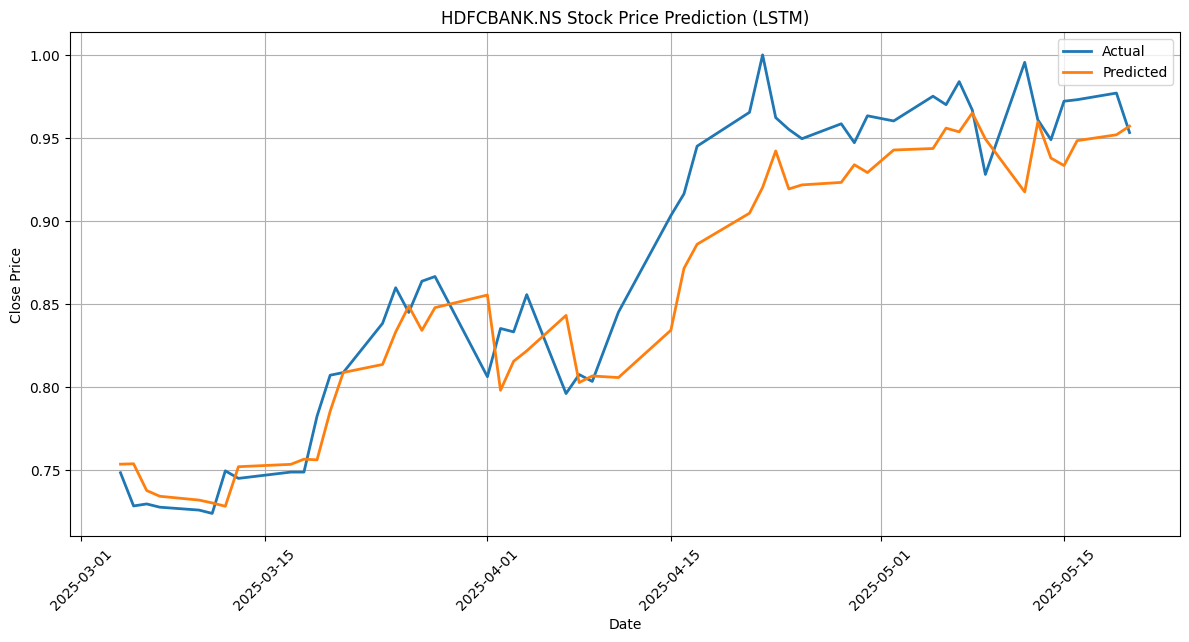

Model saved as: hdfc_bank_model.keras


In [ ]:
predict_stock_price_lstm('HDFCBANK.NS', 'HDB', 'hdfc_bank')

#ICICI

Attempt 1: Fetching data for IBN...
Successfully scraped 100 news items for IBN


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0357 - val_loss: 0.0075
Epoch 2/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.0030 - val_loss: 8.0567e-04
Epoch 3/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 4/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0027 - val_loss: 6.2224e-04
Epoch 5/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0023 - val_loss: 4.3172e-04
Epoch 6/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0023 - val_loss: 5.7866e-04
Epoch 7/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0022 - val_loss: 8.1658e-04
Epoch 8/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0022 - val_loss: 4.4592e-04
Epoch 9/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0029 - val_loss: 7.1654e-04
Epoch 10/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 11/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 12/150
62/62 ━━━━━

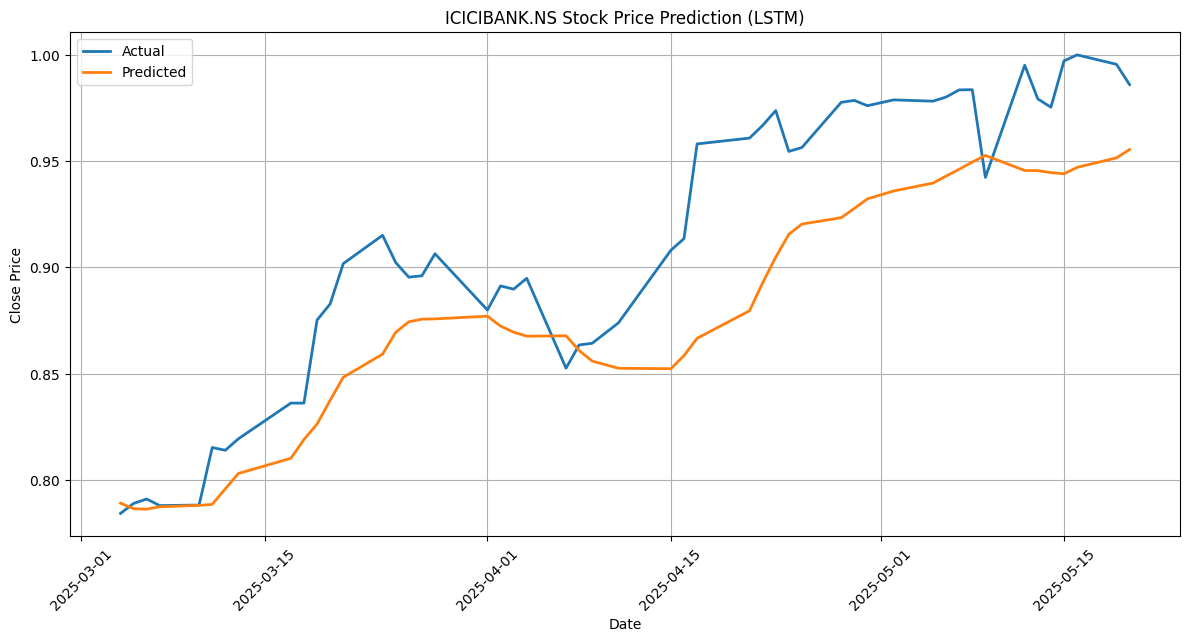

Model saved as: icici_bank_model.keras


In [ ]:
predict_stock_price_lstm('ICICIBANK.NS', 'IBN', 'icici_bank')

#Infosys

Attempt 1: Fetching data for INFY...
Attempt 1 failed: time data 'Today' does not match format '%b-%d-%y'
Retrying...
Attempt 2: Fetching data for INFY...
Attempt 2 failed: time data 'Today' does not match format '%b-%d-%y'
Retrying...
Attempt 3: Fetching data for INFY...
Attempt 3 failed: time data 'Today' does not match format '%b-%d-%y'
Max retries reached. Failed to scrape data.


0it [00:00, ?it/s]

Epoch 1/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0706 - val_loss: 0.0057
Epoch 2/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0065 - val_loss: 0.0039
Epoch 3/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0051 - val_loss: 0.0017
Epoch 4/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0059 - val_loss: 0.0153
Epoch 5/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0053 - val_loss: 0.0013
Epoch 6/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.0039 - val_loss: 0.0059
Epoch 7/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 8/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0037 - val_loss: 0.0011
Epoch 9/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 10/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0038 - val_loss: 0.0081
Epoch 11/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 12/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step

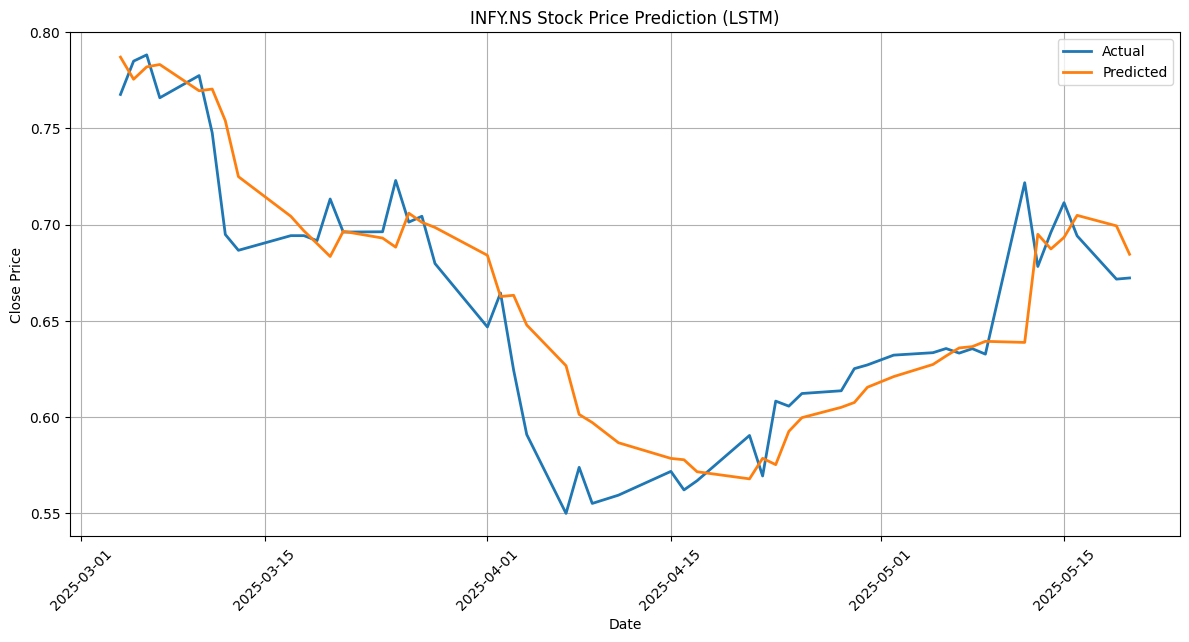

Model saved as: infosys_model.keras


In [ ]:
predict_stock_price_lstm('INFY.NS', 'INFY', 'infosys')